# **Project FBDA**
---
## Film Recommendation system using pyspark
---

| Name        | Roll Number | Section |
|-------------|-------------|---------|
| Ammar Ahmed | 20L-0961    | 4B      |
| Anas Awais  | 20L-1255     | 4B      |
| Abdul Rab   | 22L-7538   | 4B      |

# Download data and setup pyspark
---
Since pyspark doesnt come bundled in colab we will set up using python package manager and the data can be picked up using curl(*Client for URL*) or wget(*World Wide Web get*).

In [ ]:
!pip install -q pyspark
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip && rm -f ml-latest-small.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
--2024-05-24 05:44:46--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.56MB/s    in 0.2s    

2024-05-24 05:44:46 (4.56 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("MovieRecommendation") \
    .config("spark.master", "local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.cores", "2") \
    .getOrCreate()
# Read in data
ratings = spark.read.csv('/content/ml-latest-small/ratings.csv', header=True, inferSchema=True)

# Take a look at the data
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
# Get the dataset information
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [ ]:
# Number of users
print('The ratings dataset has', ratings.select("userId").distinct().count(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings.select("movieId").distinct().count(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings.select("rating").distinct().count(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings.select("rating").distinct().rdd.flatMap(lambda x: x).collect()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [ ]:
# Read in data
movies = spark.read.csv('/content/ml-latest-small/movies.csv', header=True, inferSchema=True)

# Take a look at the data
movies.show()


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

Using 'movieID' as the matching key, we appended movie information to the rating dataset and named it 'df'. So now we have the movie tile and movie rating in the same df

In [ ]:
# Merge ratings and movies datasets
df = ratings.join(movies, on='movieId', how='inner')

# Take a look at the data
df.show()


+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      1|     1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|
|     70|     1|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|
|    101|     1|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|
|    110|     1|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|
|    151|     1|   5.0|964984041|      Rob Roy (1995)|Action|Drama|Roma...|
|    157|     1|   5.0|964984100|Canadian Bacon (1...|          Comedy|War|
|    163|   

# Exploratory Data Analysis
---
filter the movies and keep only those with over 100 ratings for the analysis.

In [ ]:
from pyspark.sql.functions import mean, count
agg_ratings = df.groupBy('title').agg(
    mean('rating').alias('mean_rating'),
    count('rating').alias('number_of_ratings')
)

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings.filter(col('number_of_ratings') > 100)

# Show information about the resulting DataFrame
agg_ratings_GT100.printSchema()
agg_ratings_GT100.show()

root
 |-- title: string (nullable = true)
 |-- mean_rating: double (nullable = true)
 |-- number_of_ratings: long (nullable = false)

+--------------------+------------------+-----------------+
|               title|       mean_rating|number_of_ratings|
+--------------------+------------------+-----------------+
|Men in Black (a.k...| 3.487878787878788|              165|
|Good Will Hunting...| 4.078014184397163|              141|
|Kill Bill: Vol. 2...| 3.868181818181818|              110|
|Eternal Sunshine ...|4.1603053435114505|              131|
|       Clerks (1994)| 3.855769230769231|              104|
|Silence of the La...| 4.161290322580645|              279|
|Star Trek: Genera...|3.3935185185185186|              108|
|Dumb & Dumber (Du...|3.0601503759398496|              133|
|Apocalypse Now (1...| 4.219626168224299|              107|
|Groundhog Day (1993)| 3.944055944055944|              143|
|Indiana Jones and...| 3.638888888888889|              108|
|      Jumanji (1995)|3.43

In [ ]:
# Most popular movies and their ratings
popular_movies = agg_ratings_GT100.orderBy('number_of_ratings', ascending=False).limit(5).toPandas()
popular_movies.head()

,title,mean_rating,number_of_ratings
0,Forrest Gump (1994),4.164134,329
1,"Shawshank Redemption, The (1994)",4.429022,317
2,Pulp Fiction (1994),4.197068,307
3,"Silence of the Lambs, The (1991)",4.161290,279
4,"Matrix, The (1999)",4.192446,278


**jointplot** to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

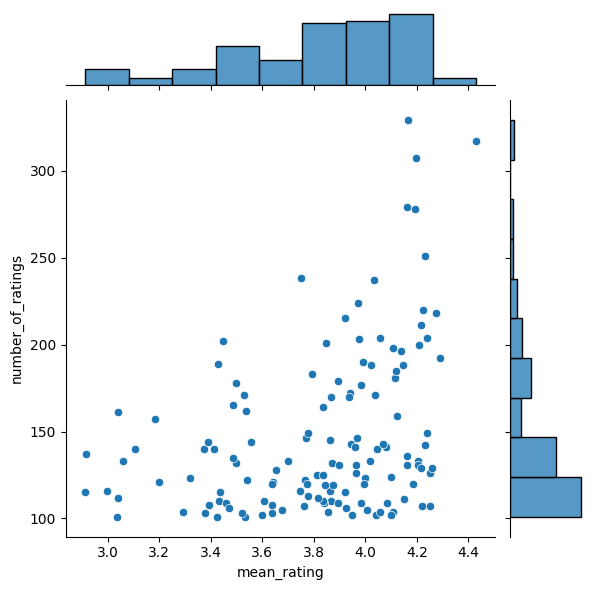

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Convert PySpark DataFrame to Pandas DataFrame
agg_ratings_GT100_pd = agg_ratings_GT100.toPandas()
# Visualization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100_pd)

join movie with user-rating level dataframe

In [ ]:
df_GT100 = df.join(agg_ratings_GT100.select('title'), on='title', how='inner')
df_GT100.printSchema()

root
 |-- title: string (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- genres: string (nullable = true)



after filtering movies with over 100 ratings

In [ ]:
# Number of users
num_users = df_GT100.select('userId').distinct().count()
print(f'The ratings dataset has {num_users} unique users')

# Number of movies
num_movies = df_GT100.select('movieId').distinct().count()
print(f'The ratings dataset has {num_movies} unique movies')

# Number of ratings
num_ratings = df_GT100.select('rating').distinct().count()
print(f'The ratings dataset has {num_ratings} unique ratings')

# List of unique ratings
unique_ratings = sorted(df_GT100.select('rating').distinct().rdd.flatMap(lambda x: x).collect())
print(f'The unique ratings are {unique_ratings}')

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Create User-Movie Matrix
---

transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [ ]:
from pyspark.sql.functions import col


# Create user-item matrix
matrix = df_GT100.groupBy('userId', 'title').pivot('title').agg({"rating": "first"})

# Fill missing values with 0 (assuming missing values mean no rating)
matrix = matrix.fillna(0)

# Show the resulting matrix
matrix.show()

+------+--------------------+----------------------------+---------------------------------+--------------+------------+-------------+----------------------------------------------------+----------------------+-------------------------+-------------------+---------------------+----------------+--------------------------------------------+-----------+-------------------------+-------------+--------------------+---------------------+------------------------+---------------------------+------------------------+-------------------+---------------------------+-----------------+--------------------------+--------------------------+-------------------------------+-------------+------------------+--------------------------+---------------+-------------------+-------------------------------------------------------+-------------------------+-----------------------+--------------------+---------------+---------------------------------+-------------------+--------------------------------------+---

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
# Create user-item matrix
matrix = df_GT100.groupBy('userId', 'title').agg(F.mean('rating').alias('rating'))
user_item_matrix = matrix.groupBy('userId').pivot('title').agg(F.first('rating'))

# Show the user-item matrix
user_item_matrix.show()



+------+----------------------------+---------------------------------+--------------+------------+-------------+----------------------------------------------------+----------------------+-------------------------+-------------------+---------------------+----------------+--------------------------------------------+-----------+-------------------------+-------------+--------------------+---------------------+------------------------+---------------------------+------------------------+-------------------+---------------------------+-----------------+--------------------------+--------------------------+-------------------------------+-------------+------------------+--------------------------+---------------+-------------------+-------------------------------------------------------+-------------------------+-----------------------+--------------------+---------------+---------------------------------+-------------------+--------------------------------------+------------------------

# Data Normalization
---

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the movies with a rating less than the user's average rating get a negative value, and the movies with a rating more than the user's average rating get a positive value.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming `matrix` is the PySpark DataFrame from the previous code

# Extract the average rating for each user
user_avg_ratings = matrix.select(
    'userId',
    *(F.mean(F.col(col)).over(Window.partitionBy('userId')).alias(f'{col}_avg') for col in matrix.columns[2:])
)

# Join the average ratings back to the user-item matrix
matrix_normalized = matrix.join(
    user_avg_ratings, on='userId', how='inner'
)

# Normalize the user-item matrix
normalized_cols = [
    ((F.col(col) - F.col(f'{col}_avg')).alias(col))
    for col in matrix.columns[2:]
]

matrix_normalized = matrix_normalized.select('userId', 'title', *normalized_cols)

# Show the normalized user-item matrix
matrix_normalized.show()

+------+--------------------+--------------------+
|userId|               title|              rating|
+------+--------------------+--------------------+
|     1| Pulp Fiction (1994)| -1.3928571428571432|
|     1|E.T. the Extra-Te...|  0.6071428571428568|
|     1|Schindler's List ...|  0.6071428571428568|
|     1|American History ...|  0.6071428571428568|
|     1|Dances with Wolve...|-0.39285714285714324|
|     1| Shining, The (1980)| -1.3928571428571432|
|     1|Monty Python and ...|  0.6071428571428568|
|     1|Green Mile, The (...|  0.6071428571428568|
|     1|Indiana Jones and...|  0.6071428571428568|
|     1|Seven (a.k.a. Se7...|  0.6071428571428568|
|     1|Mission: Impossib...| -1.3928571428571432|
|     1|Star Wars: Episod...|  0.6071428571428568|
|     1|   Fight Club (1999)|  0.6071428571428568|
|     1|    Gladiator (2000)|  0.6071428571428568|
|     1|Terminator, The (...|  0.6071428571428568|
|     1|Star Wars: Episod...|  0.6071428571428568|
|     1|      Twister (1996)| -

# Identify Similar Users
---
- userIdA and userIdB: These columns represent pairs of users.
- EuclideanDistance: This column shows the calculated "distance" between each pair, representing how different their tastes are. A smaller distance means more similar tastes.

the first row (userIdA = 580, userIdB = 23) has a distance of approximately 0.955, indicating they are fairly similar.

## User 1's Similar Users:
---

The list under similar_users for userIdA = 1 shows pairs of user IDs and distances, where each user is deemed similar to user 1 to varying degrees. For example, user 4 has a distance of about 0.997 from user 1, indicating very high similarity.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import BucketedRandomProjectionLSH

# Step 1: Initialize Spark session
spark = SparkSession.builder.appName("MovieRecommendation") \
    .config("spark.master", "local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.cores", "2") \
    .getOrCreate()
# Step 2: Create User-Item Matrix
user_item_matrix = df_GT100.groupBy('userId', 'title').agg(F.mean('rating').alias('rating'))
user_item_matrix = user_item_matrix.groupBy('userId').pivot('title').agg(F.first('rating')).fillna(0)

# Step 3: Rename Columns to Avoid Special Characters
import re

def clean_column_name(name):
    return re.sub(r'\W+', '_', name)

for col_name in user_item_matrix.columns:
    if col_name != 'userId':
        user_item_matrix = user_item_matrix.withColumnRenamed(col_name, clean_column_name(col_name))

# Step 4: Transform to Vector Format
input_cols = user_item_matrix.columns[1:]  # Skip 'userId'
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
user_features = assembler.transform(user_item_matrix).select('userId', 'features')

# Step 5: Normalize the Features
normalizer = Normalizer(inputCol="features", outputCol="normFeatures")
user_features = normalizer.transform(user_features).select('userId', 'normFeatures')

# Step 6: Compute Cosine Similarity using LSH
bucket_length = 1.0  # may adjust this value based on your dataset
brp = BucketedRandomProjectionLSH(inputCol="normFeatures", outputCol="hashes", bucketLength=bucket_length, numHashTables=3)
model = brp.fit(user_features)

# Step 7: Identify Similar Users
similar_users = model.approxSimilarityJoin(user_features, user_features, 1.0, distCol="EuclideanDistance")
similar_users = similar_users.select(
    F.col("datasetA.userId").alias("userIdA"),
    F.col("datasetB.userId").alias("userIdB"),
    F.col("EuclideanDistance")
).filter("userIdA != userIdB")

similar_users.show()

# Step 8: Sort and Retrieve Top Similar Users for each user
top_similar_users = similar_users.groupBy("userIdA").agg(F.collect_list(F.struct("userIdB", "EuclideanDistance")).alias("similar_users"))
top_similar_users.show(truncate=False)


+-------+-------+-------------------+
|userIdA|userIdB|  EuclideanDistance|
+-------+-------+-------------------+
|    307|     16|  0.906145120511532|
|    307|    274|0.44864333739586104|
|    307|    480| 0.4886424452365951|
|    307|    596|   0.76998492913197|
|    307|    385|  0.919824380135297|
|    307|     18| 0.5934532256847147|
|    229|    498| 0.8328890429254102|
|    220|    475| 0.9255352344816443|
|    494|     30| 0.9673712251835698|
|    243|    235| 0.9453276688914795|
|    580|     66| 0.6761608203011964|
|    580|    199| 0.8209589831091022|
|    580|    115| 0.9747133098509414|
|    580|    368| 0.8566068644606847|
|    555|    202| 0.7540918465797973|
|     39|     95| 0.9947267663566571|
|    380|    607| 0.9237006925737987|
|    380|    266| 0.8576801594975119|
|    380|     86| 0.9130715201287333|
|    380|    356| 0.9058293762122158|
+-------+-------+-------------------+
only showing top 20 rows

+-------+-----------------------------------------------------

Now goal is to recommend the top 10 movies to a target user (User ID 1) based on a combination of user similarity scores and movie ratings from other similar users. This approach integrates both the similarities between users and their respective ratings to determine personalized movie recommendations.

### Steps to Compute Recommendations
---
- **Filter Similar Users**:
   - Identify users similar to the target user from the `similar_users` DataFrame, which contains pairs of users and their similarity scores.
   - Filter out entries where `userIdA` equals `userIdB` to avoid self-influence in the recommendations.

- **Join Ratings Data**:
   - Merge the filtered `similar_users` DataFrame with the `df` DataFrame (which contains user ratings and movie information), matching on the user ID of similar users. This associates each rating made by similar users with their corresponding similarity scores to the target user.

- **Calculate Weighted Ratings**:
   - Compute the weighted rating for each movie by multiplying the movie rating by the similarity score. This emphasizes ratings from users who are more similar to the target user.

- **Aggregate Ratings**:
   - For each movie, sum up the weighted ratings and the total similarity scores to normalize the ratings properly.

- **Compute Recommendation Scores**:
   - Calculate the final recommendation score for each movie as the total weighted ratings divided by the total similarity scores. This score represents the expected enjoyment of the target user, based on the preferences of similar users.

- **Select Top Movies**:
   - Sort the movies by their computed scores in descending order and select the top 10. These movies are the ones most likely to be appreciated by the target user, given the preferences of users with similar tastes.

### The result
The final list represents a personalized set of movie recommendations for the target user, tailored according to both the movie ratings and the degree of similarity between the users who have rated these movies and the target user.


In [ ]:
from pyspark.sql import functions as F

# the target user
target_user_id = 1

# similar users DataFrame for target user and remove any self matches
similar_users = similar_users.filter(
    (similar_users.userIdA == target_user_id) & (similar_users.userIdA != similar_users.userIdB)
)

# Rename columns
similar_users = similar_users.withColumnRenamed('userIdB', 'similarUserId').withColumnRenamed('EuclideanDistance', 'similarity')

weighted_ratings = df.join(
    similar_users, df.userId == similar_users.similarUserId, 'inner'
)

weighted_ratings = weighted_ratings.withColumn(
    'weighted_rating', F.col('rating') * F.col('similarity')
)

movie_recommendations = weighted_ratings.groupBy('movieId', 'title').agg(
    F.sum('weighted_rating').alias('sum_weighted_rating'),
    F.sum('similarity').alias('sum_similarity')
)

movie_recommendations = movie_recommendations.withColumn(
    'score', F.col('sum_weighted_rating') / F.col('sum_similarity')
)

# grab top 10
top_movies = movie_recommendations.orderBy(F.col('score').desc()).limit(10)

top_movies.show()

+-------+--------------------+-------------------+------------------+-----------------+
|movieId|               title|sum_weighted_rating|    sum_similarity|            score|
+-------+--------------------+-------------------+------------------+-----------------+
|   3746|Butterfly (La len...|  4.293352893589393|0.8586705787178786|5.000000000000001|
|   2511|Long Goodbye, The...| 4.7558644361306595|0.9511728872261318|5.000000000000001|
|   3096|My Man Godfrey (1...| 4.7558644361306595|0.9511728872261318|5.000000000000001|
|   5607|Son of the Bride ...|  4.293352893589393|0.8586705787178786|5.000000000000001|
|   5328|         Rain (2001)| 4.1424418876035904|0.8284883775207181|              5.0|
| 115727|Crippled Avengers...|  4.433156263979257|0.8866312527958515|              5.0|
|   4495|Crossing Delancey...|  4.269653187495505| 0.853930637499101|              5.0|
|  74282|Anne of Green Gab...|  4.653461551162609|0.9306923102325219|              5.0|
|   2512|Ballad of Narayam...|  

# predicting user-specific movie ratings
---
- **User Average Rating Calculation**: First, the average rating by the target user (User ID 1 in this case) was calculated across all the movies they have rated. This can represent the user's general tendency towards rating movies.
  
- **Adjusting the Scores**: Each movie's score is then adjusted by adding the target user's average rating. This step recalibrates the scores to be more reflective of the user's rating scale and preferences.

- **the Final Recommendations**: The final DataFrame now includes movies along with their original scores and the adjusted predicted ratings, showing what the user might rate these movies based on their past behavior.

Hence recommendations are personalized not just by similarity to other users' tastes but also adjusted to reflect how the user typically rates movies.

In [ ]:
from pyspark.sql.functions import avg

# the target user
target_user_id = 1

# Calculate Average Rating for the Target User
user_avg_rating = df.filter(df.userId == target_user_id).select(avg("rating")).alias("avg_rating")

avg_rating = user_avg_rating.collect()[0][0]

# recommendation scores with the average rating
final_recommendations = movie_recommendations.withColumn("predicted_rating", F.col("score") + avg_rating)

# final recommendations including the predicted ratings
final_recommendations.select("movieId", "title", "score", "predicted_rating").show(truncate=False)


+-------+----------------------------------------------------+------------------+-----------------+
|movieId|title                                               |score             |predicted_rating |
+-------+----------------------------------------------------+------------------+-----------------+
|45447  |Da Vinci Code, The (2006)                           |3.024618880938443 |7.39099819128327 |
|4085   |Beverly Hills Cop (1984)                            |3.4469091156617973|7.813288426006625|
|2657   |Rocky Horror Picture Show, The (1975)               |3.183048359026277 |7.549427669371104|
|2907   |Superstar (1999)                                    |3.1692437591753455|7.535623069520173|
|2346   |Stepford Wives, The (1975)                          |3.391569376869515 |7.757948687214343|
|2076   |Blue Velvet (1986)                                  |4.137422952198788 |8.503802262543616|
|800    |Lone Star (1996)                                    |4.217979639758615 |8.584358950103443|


# Alternating Least Squares (ALS) algorithm
---
 This method will provide personalized movie recommendations based on implicit feedback (user ratings).

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("ALS Movie Recommendation") \
    .config("spark.master", "local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.cores", "2") \
    .getOrCreate()

**Load and Prepare Data**

Loading the ratings data into a DataFrame. Ensure that the necessary columns ('userId', 'movieId', and 'rating') are in the correct format (integer) for ALS.


In [ ]:
# Load data
ratings = spark.read.csv('/content/ml-latest-small/ratings.csv', header=True, inferSchema=True)

# Select and typecast columns
ratings = ratings.select(
    ratings.userId.cast("int"),
    ratings.movieId.cast("int"),
    ratings.rating.cast("float")
)

# Show DataFrame structure
ratings.printSchema()
ratings.show(5)


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



**Configure and Train ALS Model**

Set up the ALS model with parameters optimized for collaborative filtering. Here, we specify the user and item columns, and the rating column to predict. Additionally, the model is trained to handle implicit feedback.


**Evaluate Model Performance**

Use the `RegressionEvaluator` to assess how well the model is performing in terms of predicting user ratings. This will help us understand the accuracy of our recommendations.


In [ ]:
# ALS algorithm parameters
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

# RegressionEvaluator for measuring the model's performance
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
# Split data into training and testing sets
(train_data, test_data) = ratings.randomSplit([0.8, 0.2])

# Re-train the ALS model on the training data
model = als.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the predictions
rmse = evaluator.evaluate(predictions)

# Print the RMSE
print(f"Root Mean Squared Error (RMSE) on test data = {rmse:.2f}")


Root Mean Squared Error (RMSE) on test data = 1.02


**Generate Recommendations**

Using the trained ALS model, generate top 10 movie recommendations for each user. I will leverages the model's `recommendForAllUsers` method which efficiently predicts the top items for all users.


In [23]:
# Generate top 10 movie recommendations for each user
user_recommendations = model.recommendForAllUsers(10)

# Show example recommendations
user_recommendations.show(5, truncate=False)


+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                              |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{70994, 7.5636907}, {89904, 7.2138534}, {190, 6.853307}, {3477, 6.838999}, {148881, 6.824972}, {7008, 6.7928543}, {4535, 6.7116}, {40491, 6.664624}, {3676, 6.577311}, {171495, 6.4998126}] |
|2     |[{70994, 12.809187}, {89904, 9.501153}, {674, 8.737798}, {932, 8.538045}, {49932, 8.478292}, {130634, 8.4369755}, {89118, 8.30434}, {79185, 8.129451}, {104457, 8.064794}, {30, 7.8131866}]  |
|3   

**Map Recommendations to Movie Titles**

After obtaining the recommendations, I join them with the movie titles to provide a more understandable list of recommendations, displaying movie titles instead of movie IDs.


In [24]:
# Load the movies data
movies = spark.read.csv('/content/ml-latest-small/movies.csv', header=True, inferSchema=True)

movie_titles = movies.select("movieId", "title")

recommendations_exploded = user_recommendations \
    .withColumn("rec_exp", F.explode("recommendations")) \
    .select("userId", F.col("rec_exp.movieId"), F.col("rec_exp.rating"))

recommendations_with_titles = recommendations_exploded.join(movie_titles, on="movieId")

# final recommendations with titles
recommendations_with_titles.select("userId", "title", "rating").show(10, truncate=False)


+------+-------------------------------------------------------+---------+
|userId|title                                                  |rating   |
+------+-------------------------------------------------------+---------+
|1     |Halloween II (2009)                                    |7.5636907|
|1     |The Artist (2011)                                      |7.2138534|
|1     |Safe (1995)                                            |6.853307 |
|1     |Empire Records (1995)                                  |6.838999 |
|1     |World of Tomorrow (2015)                               |6.824972 |
|1     |Last Tango in Paris (Ultimo tango a Parigi) (1972)     |6.7928543|
|1     |Man from Snowy River, The (1982)                       |6.7116   |
|1     |Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)|6.664624 |
|1     |Eraserhead (1977)                                      |6.577311 |
|1     |Cosmos                                                 |6.4998126|
+------+-----------------